In [1]:
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import termcolor
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# from vit_pipeline import lrs, vit_model_names
from data_preprocessing import granularities
from metacognitive_pipeline import fine_grain_classes, n_classes
from context import Plot

In [2]:
data_dir = 'results/'  # Set the directory where your .npy files are located
all_data = {}

for granularity in granularities.values():
    
    suffix = '_coarse' if granularity == 'coarse' else ''
    # Initialize dictionaries to store training and test accuracy data for each model
    train_data = {}
    test_data = {}
    
    test_true = np.load(os.path.join(data_dir, f'test_true{suffix}.npy'))
    
    # Loop through all files in the directory
    for filename in os.listdir(data_dir):
        train_match = re.match(pattern=rf'(.+?)_train_(loss|acc)_lr(.+?)_e(\d+?){suffix}.npy',
                               string=filename)
        test_match = re.match(pattern=rf'(.+?)_test_pred_lr(.+?)_e(\d+?){suffix}.npy',
                              string=filename)
    
        if train_match:
            model_name = train_match.group(1)
            metric = train_match.group(2)
            lr_value = float(train_match.group(3))
            num_epochs = int(train_match.group(4)) + 1
    
            # Load the data from the .npy file
            data = np.load(os.path.join(data_dir, filename))
    
            # Store the data in the model_data dictionary
            if model_name not in train_data:
                train_data[model_name] = {}
            if metric not in train_data[model_name]:
                train_data[model_name][metric] = {}
            if lr_value not in train_data[model_name][metric]:
                train_data[model_name][metric][lr_value] = {}
    
            train_data[model_name][metric][lr_value][num_epochs] = data[-1]
        elif test_match:
            model_name = test_match.group(1)
            lr_value = float(test_match.group(2))
            num_epochs = int(test_match.group(3)) + 1
    
            # Load the test data from the .npy file
            test_pred = np.load(os.path.join(data_dir, filename))
    
            # Store the data in the model_test_data dictionary
            if model_name not in test_data:
                test_data[model_name] = {}
            if lr_value not in test_data[model_name]:
                test_data[model_name][lr_value] = {}
    
            test_data[model_name][lr_value][num_epochs] = \
                {'acc': accuracy_score(y_true=test_true, 
                                       y_pred=test_pred), 
                 'cm': confusion_matrix(y_true=test_true, 
                                        y_pred=test_pred),
                 'pre': precision_score(y_true=test_true, 
                                        y_pred=test_pred, 
                                        labels=range(n_classes), 
                                        average=None),
                 'rec': recall_score(y_true=test_true, 
                                     y_pred=test_pred, 
                                     labels=range(n_classes), 
                                     average=None),
                 'f1': f1_score(y_true=test_true, 
                                y_pred=test_pred, 
                                labels=range(n_classes), 
                                average=None)}
            
    all_data[granularity] = {'train': train_data, 'test': test_data}

# Fine Grain

## Train metrics


############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


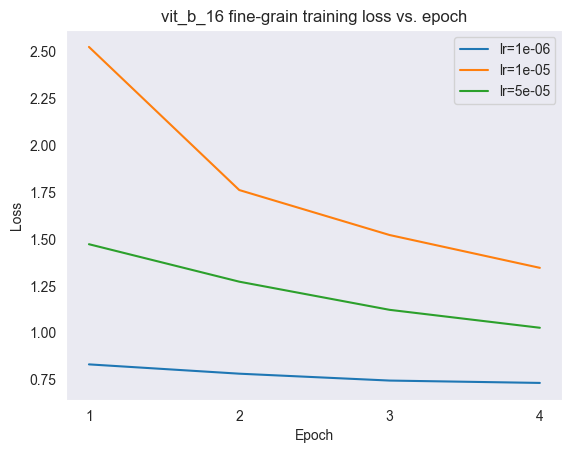

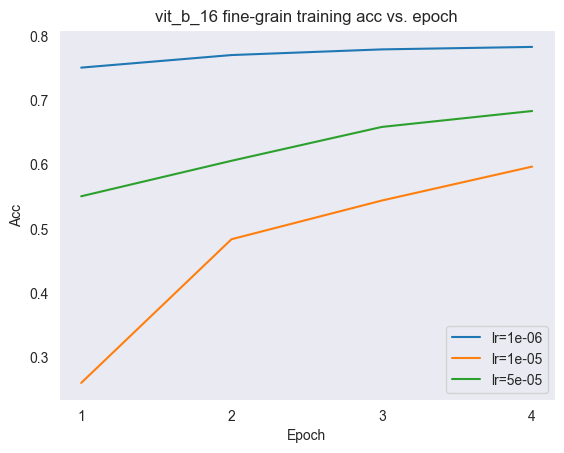


############################################################################################################
##################################################vit_b_32##################################################
############################################################################################################


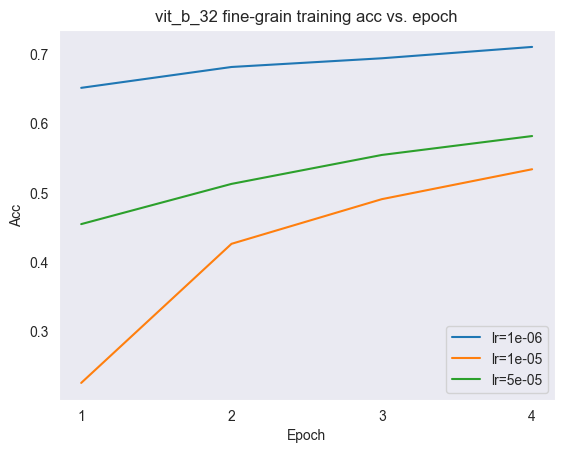

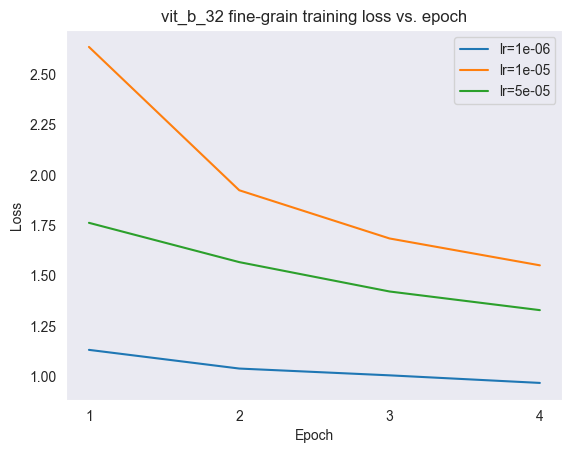


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


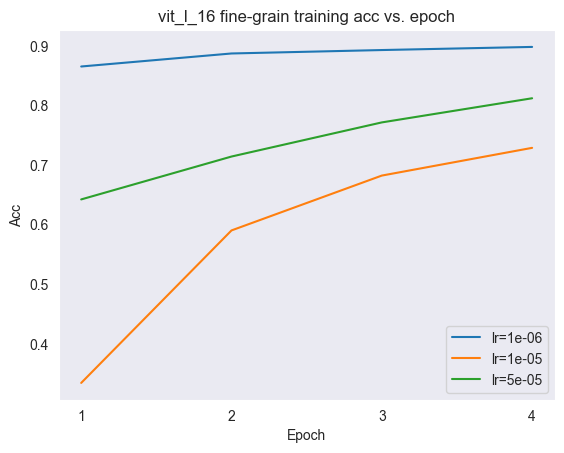

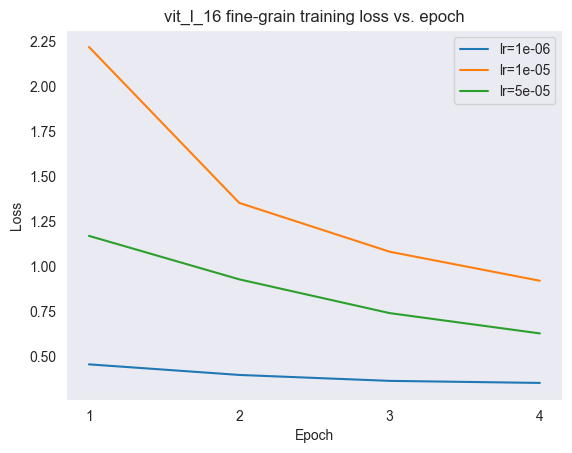


############################################################################################################
##################################################vit_l_32##################################################
############################################################################################################


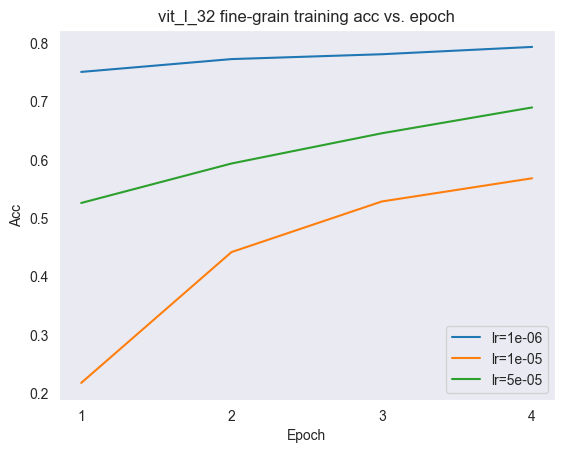

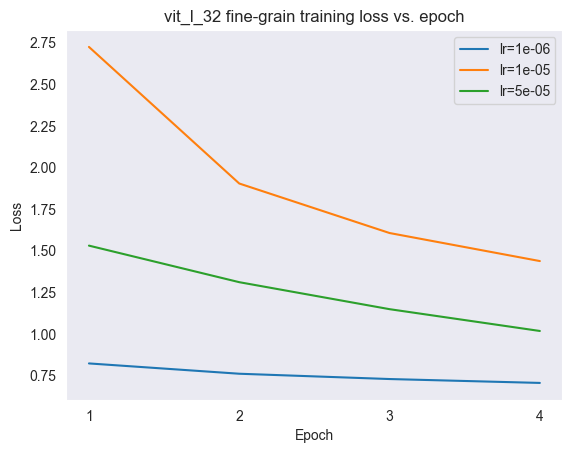

<Figure size 640x480 with 0 Axes>

In [3]:
def plot_train_metrics(granularity: str):
    # Create plots for training metric vs. epoch for each model
    for model_name, model_data in sorted(all_data[granularity]['train'].items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        for metric, metric_data in model_data.items():
            with Plot():
                plt.title(f"{model_name} {granularity}-grain training {metric} vs. epoch")
                plt.xlabel('Epoch')
                plt.ylabel(metric.capitalize())
    
                for lr_value, lr_data in sorted(metric_data.items()):
                    epochs, data = zip(*sorted(lr_data.items())) # Sort the data based on the number of epochs
                    plt.plot(epochs, data, label=f'lr={lr_value}')
                    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
    
                plt.legend()
                plt.grid()

plot_train_metrics(granularity='fine')

# Test metrics

In [4]:
def plot_test_metrics(granularity: str):
    # Create a dictionary to store accuracy values for each model and learning rate
    accuracy_data = {}

    # Now, create plots for test accuracy vs. epoch for each model
    for model_name, model_data in sorted(all_data[granularity]['test'].items()):
        for lr_value, lr_data in sorted(model_data.items()):
            # Collect the accuracy after the last epoch
            last_epoch = sorted(lr_data.items())[-1][1]
            accuracy = last_epoch['acc']

            # Store the accuracy in the dictionary
            if model_name not in accuracy_data:
                accuracy_data[model_name] = {}
            accuracy_data[model_name][f'lr={lr_value}'] = accuracy

    # Get a list of all learning rates in the data
    all_learning_rates = sorted(set(lr for model_data in accuracy_data.values() for lr in model_data))

    # Generate the 2-D table with manual headers
    headers = ["Model Name"] + all_learning_rates
    table = []
    
    for model_name in accuracy_data:
        row = [model_name] + [accuracy_data[model_name].get(lr, "N/A") for lr in all_learning_rates]
        table.append(row)
    
    # Adding a title to the table
    title = f"Test Metrics for Granularity: {granularity}"
    
    # Generate the table using tabulate
    table_str = tabulate(table, headers=headers, tablefmt="fancy_grid")

    # Insert the title in the middle of the table
    lines = table_str.split('\n')
    lines.insert(0, title.center(len(lines[0])))
    updated_table = '\n'.join(lines)

    # Print the updated table with the title
    print(updated_table)

plot_test_metrics(granularity='fine')

           Test Metrics for Granularity: fine          
╒══════════════╤════════════╤════════════╤════════════╕
│ Model Name   │   lr=1e-05 │   lr=1e-06 │   lr=5e-05 │
╞══════════════╪════════════╪════════════╪════════════╡
│ vit_b_16     │   0.639112 │   0.699568 │   0.645281 │
├──────────────┼────────────┼────────────┼────────────┤
│ vit_b_32     │   0.558914 │   0.636644 │   0.537323 │
├──────────────┼────────────┼────────────┼────────────┤
│ vit_l_16     │   0.699568 │   0.702653 │   0.661937 │
├──────────────┼────────────┼────────────┼────────────┤
│ vit_l_32     │   0.582357 │   0.673041 │   0.624306 │
╘══════════════╧════════════╧════════════╧════════════╛



############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


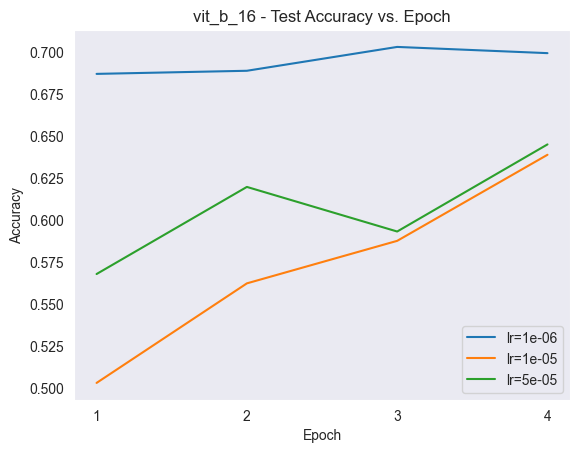


############################################################################################################
##################################################vit_b_32##################################################
############################################################################################################


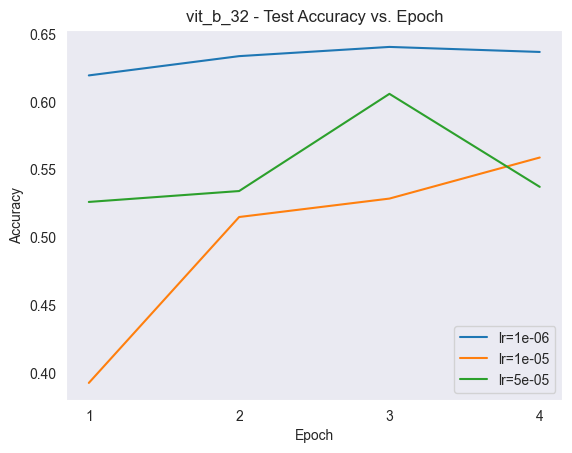


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


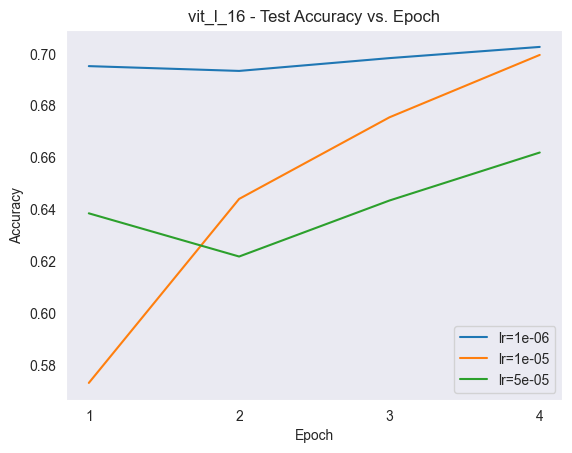


############################################################################################################
##################################################vit_l_32##################################################
############################################################################################################


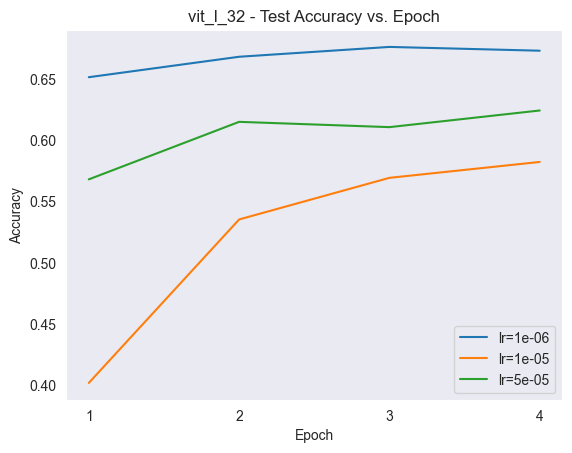

<Figure size 640x480 with 0 Axes>

In [5]:
def plot_verbose_test_metrics(granularity: str,
                              confusion_matrices: bool = False, 
                              class_wise_accuracies: bool = False):
    # Now, create plots for test accuracy vs. epoch for each model
    for model_name, model_data in sorted(all_data[granularity]['test'].items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        metric = 'Accuracy'
        
        with Plot():
            plt.title(f"{model_name} - Test {metric} vs. Epoch")
            plt.xlabel('Epoch')
            plt.ylabel(metric)
    
            for lr_value, lr_data in sorted(model_data.items()):
                # Sort the data based on the number of epochs
                epochs, epoch_data = zip(*sorted(lr_data.items()))
                plt.plot(epochs, [curr_data['acc'] for curr_data in epoch_data], label=f'lr={lr_value}')
                plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
    
            plt.legend()
            plt.grid()
        
        if confusion_matrices or class_wise_accuracies:
            for lr_value, lr_data in sorted(model_data.items()):
                epochs, epoch_data = zip(*sorted(lr_data.items()))
                
                if confusion_matrices:
                    with Plot():
                        plt.figure(figsize=(12, 9))
                        sns.heatmap(epoch_data[-1]['cm'], 
                                    annot=True, 
                                    fmt="d",  
                                    xticklabels=fine_grain_classes, 
                                    yticklabels=fine_grain_classes
                                    )
        
                        plt.xlabel('Predicted')
                        plt.ylabel('Actual')
                        plt.title(f'{model_name}, lr={lr_value} Confusion Matrix')
                
                if class_wise_accuracies:
                    for class_label, class_name in enumerate(fine_grain_classes):
                        precision = epoch_data[-1]['pre'][class_label]
                        print(f'{model_name}, lr={lr_value}, {class_name}: Precision = {precision:.2f}')

            
plot_verbose_test_metrics(granularity='fine')

# EDCR Results

In [6]:
models_and_lrs_folders = os.listdir(f'figs')
# assert (len(vit_model_names) - 1) * (len(vit_model_names) - 2) * len(lrs) ** 2  == len(models_and_lrs_folders) - 1

len(models_and_lrs_folders) - 1

180

In [7]:
def print_EDCR_results(granularity: str):
    suffix = '_coarse' if granularity == 'coarse' else ''
    test_true = np.load(os.path.join(data_dir, f'test_true{suffix}.npy'))
    
    for filename in models_and_lrs_folders:
        match = re.match(pattern=f'main_(.+?)_lr(.+?)_secondary_(.+?)_lr(.+)_{granularity}',
                         string=filename)
        if match:
            main_model_name, main_lr, secondary_model_name, secondary_lr = (match.group(i) for i in range(1,5))
            prior_predictions = np.load(os.path.join(data_dir, 
                                                     f'{main_model_name}_test_pred_lr{main_lr}_e3{suffix}.npy'))
            prior_acc = accuracy_score(y_true=test_true, 
                                       y_pred=prior_predictions)
            
            post_predictions = np.load(fr'figs/{match.group(0)}/results{suffix}.npy')
            posterior_acc = accuracy_score(y_true=test_true, 
                                           y_pred=post_predictions)
            print('#' * 100 + f'Main: {main_model_name} with lr {main_lr}, '
                              f'secondary: {secondary_model_name} with lr {secondary_lr}\n'
                  f'Prior acc:{prior_acc}, post acc: {posterior_acc}\n')
            print(termcolor.colored(f"Total acc change {'+' if posterior_acc > prior_acc else ''}"
                                    f"{round((posterior_acc - prior_acc)*100, 3)}%", 
                                    'green' if posterior_acc > prior_acc else 'red'))

# print_EDCR_results(granularity='fine')

In [8]:
def print_EDCR_table(granularity: str):
    suffix = '_coarse' if granularity == 'coarse' else ''
    # Sample data structure (replace this with your actual data)
    data = {}  # Create an empty dictionary to store the accuracy data
    
    # Track the maximal accuracy value across all tables
    max_accuracy = -1.0
    max_data = {}
    
    test_true = np.load(os.path.join(data_dir, f'test_true{suffix}.npy'))
    
    # Iterate through filenames to collect accuracy data
    for filename in models_and_lrs_folders:
        match = re.match(pattern=rf'main_(.+?)_lr(.+?)_secondary_(.+?)_lr(.+)_{granularity}', 
                         string=filename)
        if match:
            main_model_name, main_lr, secondary_model_name, secondary_lr = (match.group(i) for i in range(1, 5))
            prior_predictions = np.load(os.path.join(data_dir, rf'{main_model_name}_test_pred_lr{main_lr}_e3{suffix}.npy'))
            prior_acc = accuracy_score(y_true=test_true, 
                                       y_pred=prior_predictions)
    
            post_predictions = np.load(f'figs/{match.group(0)}/results{suffix}.npy')
            posterior_acc = accuracy_score(y_true=test_true, 
                                           y_pred=post_predictions)
    
            # Update the maximal accuracy value
            if posterior_acc > max_accuracy:
                max_accuracy = posterior_acc
                max_data = {'main_model_name': main_model_name,
                            'main_lr': main_lr,
                            'secondary_model_name': secondary_model_name,
                            'secondary_lr': secondary_lr}
    
            # Store accuracy data in the data dictionary
            if main_model_name not in data:
                data[main_model_name] = {}
            if main_lr not in data[main_model_name]:
                data[main_model_name][main_lr] = {}
            if secondary_model_name not in data[main_model_name][main_lr]:
                data[main_model_name][main_lr][secondary_model_name] = {}
                
            data[main_model_name][main_lr][secondary_model_name][secondary_lr] = {'prior': prior_acc, 
                                                                                  'post': posterior_acc}
    
    # Loop through each main model and generate a table
    for main_model_name, main_lr_data in data.items():
        table_data = []
    
        # Get a list of learning rates from the first secondary model
        main_learning_rates = sorted(main_lr_data.keys())
        
        secondary_models_data = list(main_lr_data.values())
        # Sort the secondary model names
        sorted_secondary_models = sorted(secondary_models_data[0].keys())
    
        # Create the header row with learning rates
        header = [''] + main_learning_rates
        table_data.append(header)
    
        # Add rows for each secondary model, ensuring they are sorted
        for secondary_model_name in sorted_secondary_models:
            row = [secondary_model_name] + ['\n'.join([f"{secondary_lr}: {round(data[main_model_name][main_lr][secondary_model_name][secondary_lr]['post']*100, 1)}% "
                                        f"({round(data[main_model_name][main_lr][secondary_model_name][secondary_lr]['prior']*100, 1)}%, "
                                        + termcolor.colored(f"{'+' if data[main_model_name][main_lr][secondary_model_name][secondary_lr]['post'] > data[main_model_name][main_lr][secondary_model_name][secondary_lr]['prior'] else ''}", color='green') +
                                        termcolor.colored(f"{round((data[main_model_name][main_lr][secondary_model_name][secondary_lr]['post'] - data[main_model_name][main_lr][secondary_model_name][secondary_lr]['prior'])*100, 1)}%)", color='green' if data[main_model_name][main_lr][secondary_model_name][secondary_lr]['post'] > data[main_model_name][main_lr][secondary_model_name][secondary_lr]['prior'] else 'red')
                                        + '\n' for secondary_lr in main_learning_rates])
                                       for main_lr in main_learning_rates]
            table_data.append(row)
    
        # Find the maximal accuracy value and its position in the table
        # max_acc_value = max(max([element.split()[0] for element in row[1:]] for row in table_data[1:]))
        # max_acc_row, max_acc_col = [(i, row.index(max_acc_value)) 
        #                             for i, row in enumerate(table_data) if max_acc_value in row][0]
        # 
        # # Colorize the maximal accuracy cell in green
        # table_data[max_acc_row][max_acc_col] = termcolor.colored(text=max_acc_value, 
        #                                                          color='green')
    
        # Create the table using tabulate
        table = tabulate(tabular_data=table_data, 
                         headers='firstrow', 
                         tablefmt='grid')
    
        # Print the main model name and the corresponding table
        print(f"{granularity.capitalize()}-grain with main Model: {main_model_name}")
        print(table)
        print("\n")
    
    # Print the maximal accuracy value across all tables (already colored in green)
    print(f"Overall maximal post accuracy {round(max_accuracy*100, 1)}%")
    print(max_data)

print_EDCR_table(granularity='fine')

Fine-grain with main Model: vit_b_16
+----------+-----------------------------+-----------------------------+-----------------------------+
|          | 1e-05                       | 1e-06                       | 5e-05                       |
+==========+=============================+=============================+=============================+
| vit_b_32 | 1e-05: 63.7% (63.9%, -0.2%) | 1e-05: 70.0% (70.0%, 0.0%)  | 1e-05: 64.5% (64.5%, 0.0%)  |
|          |                             |                             |                             |
|          | 1e-06: 65.0% (63.9%, +1.1%) | 1e-06: 70.0% (70.0%, +0.1%) | 1e-06: 64.3% (64.5%, -0.2%) |
|          |                             |                             |                             |
|          | 5e-05: 63.8% (63.9%, -0.1%) | 5e-05: 69.8% (70.0%, -0.1%) | 5e-05: 64.1% (64.5%, -0.4%) |
+----------+-----------------------------+-----------------------------+-----------------------------+
| vit_l_16 | 1e-05: 65.5% (63.9%, +1

# Coarse grain


############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


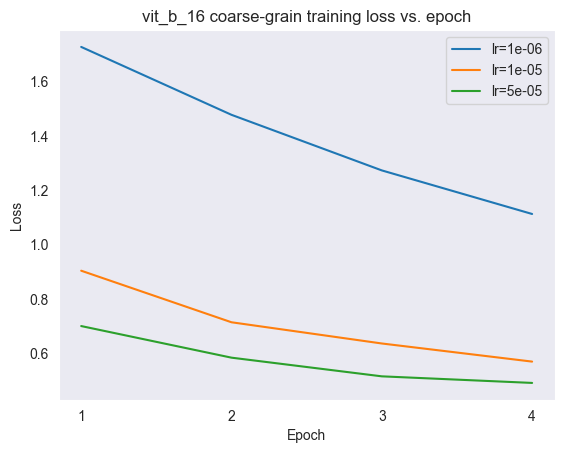

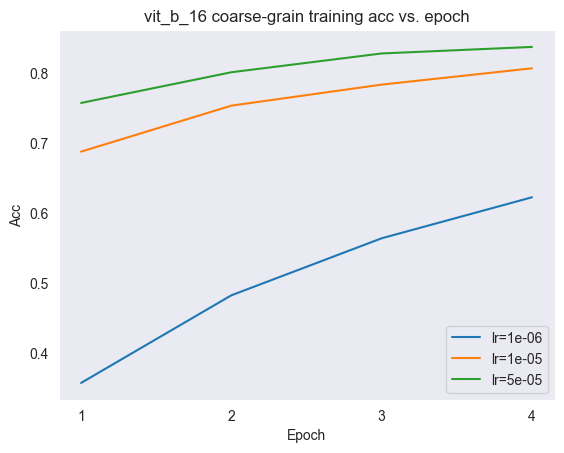


############################################################################################################
##################################################vit_b_32##################################################
############################################################################################################


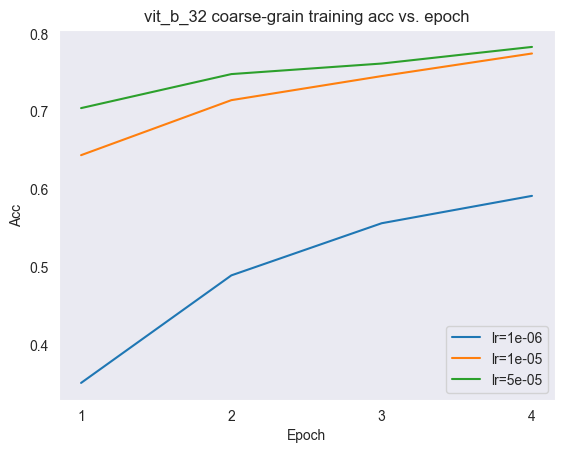

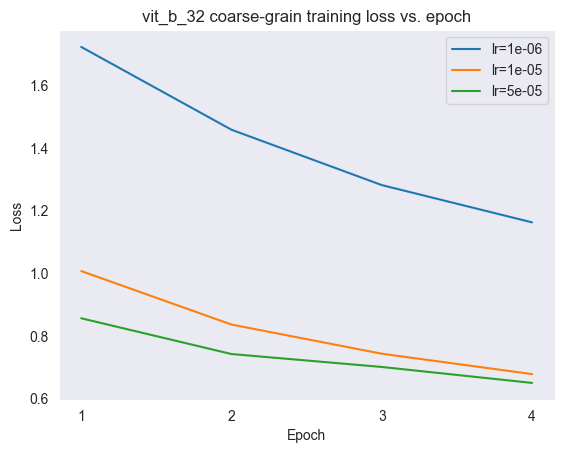


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


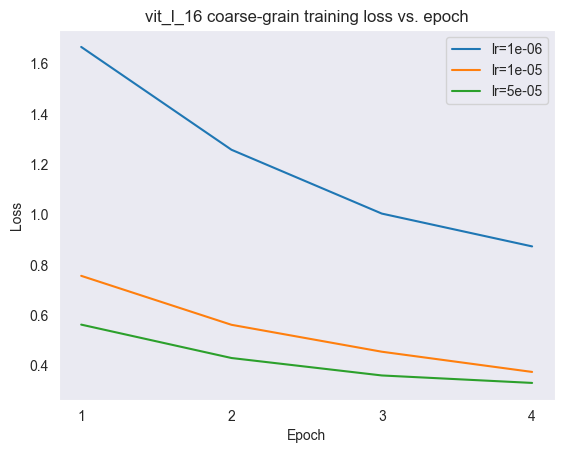

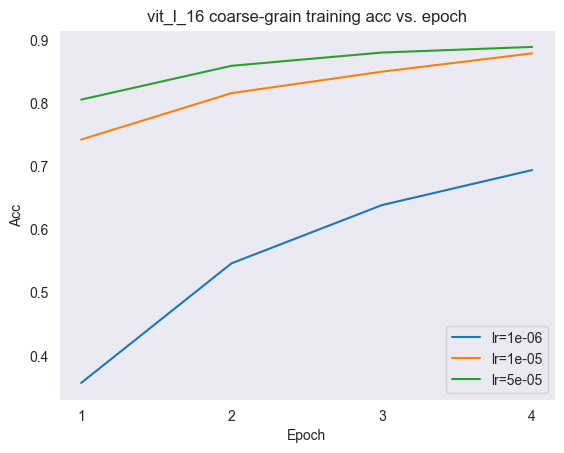


############################################################################################################
##################################################vit_l_32##################################################
############################################################################################################


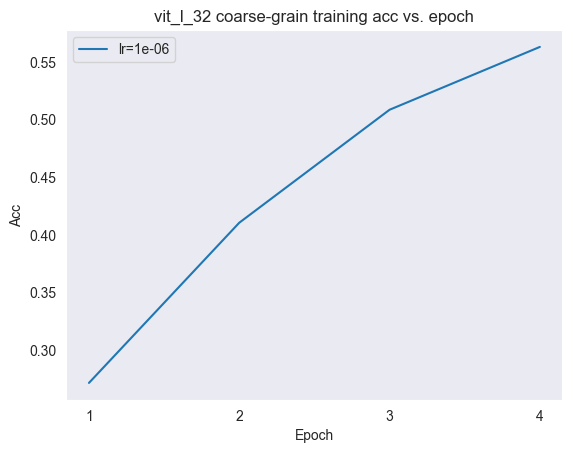

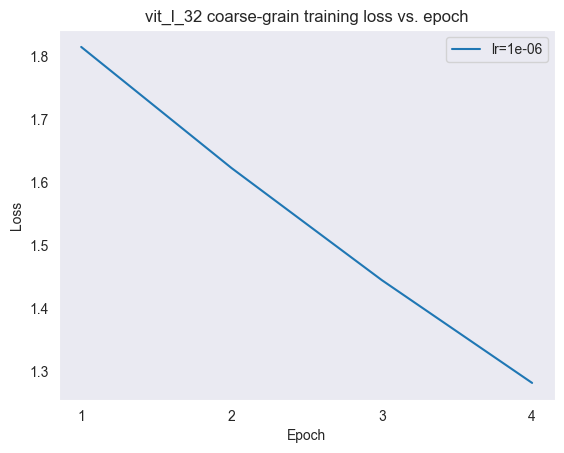

<Figure size 640x480 with 0 Axes>

In [9]:
plot_train_metrics(granularity='coarse')

In [10]:
plot_test_metrics(granularity='coarse')

                  Test Metrics for Granularity: coarse                 
╒══════════════╤════════════════════╤════════════╤════════════════════╕
│ Model Name   │ lr=1e-05           │   lr=1e-06 │ lr=5e-05           │
╞══════════════╪════════════════════╪════════════╪════════════════════╡
│ vit_b_16     │ 0.8260333127698951 │   0.665022 │ 0.8266502159161012 │
├──────────────┼────────────────────┼────────────┼────────────────────┤
│ vit_b_32     │ 0.7816162862430598 │   0.634793 │ 0.7933374460209747 │
├──────────────┼────────────────────┼────────────┼────────────────────┤
│ vit_l_16     │ 0.8352868599629858 │   0.724244 │ 0.8402220851326342 │
├──────────────┼────────────────────┼────────────┼────────────────────┤
│ vit_l_32     │ N/A                │   0.604565 │ N/A                │
╘══════════════╧════════════════════╧════════════╧════════════════════╛


In [11]:
print_EDCR_table(granularity='coarse')

Coarse-grain with main Model: vit_l_32
+----------+------------------------------+
|          | 1e-06                        |
+==========+==============================+
| vit_b_16 | 1e-06: 63.6% (60.5%, +3.1%)  |
+----------+------------------------------+
| vit_b_32 | 1e-06: 62.2% (60.5%, +1.7%)  |
+----------+------------------------------+
| vit_l_16 | 1e-06: 70.8% (60.5%, +10.4%) |
+----------+------------------------------+


KeyError: '1e-05'